In [1]:
from keras.models import load_model
import keraOverlay as overlay
import numpy as np
import matplotlib.pyplot as plt 
import utils

/home/yuan/Software/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Load preliminary trained model
model = load_model('Scale_down64.h5', custom_objects={'dice_coef_loss': overlay.dice_coef_loss,
                                                      'dice_coef': overlay.dice_coef})

In [20]:
# Load data and masks as dicom files
data_dir = '../../data'                   #Please change the path accordingly before make any changes
validation_names = data_dir + '/GoodData_256auto.txt'
img_dir = data_dir + '/256Auto/images'
msk_dir = data_dir + '/256Auto/masks'
namelist = []

with open(validation_names) as f:
    content = f.readlines()
    namelist = [x.strip() for x in content] 

In [4]:
#Load data to check first as lists
#from imp import reload
#reload(utils)
sigma = 1.0
x_list, y_list = utils.load_data(img_dir, msk_dir, namelist, padding=True, sigma_image=sigma, scaling=4, OPaslist=True)

In [12]:
#predict all data and calculate dice score and store
from keras import backend
n_slice = 64
size = 64
print(len(x_list))
index = 9
confidence = 0.9

predictions = []
dice_scores = []
predic_forscal = []
text_file = open("dice_scores_lowres.txt", "w")

for i, image in enumerate(x_list):
    mask = y_list[i]
    predictions.append(model.predict(image.reshape(1, n_slice, size, size, 1), steps=1))
    predic_forscal.append(predictions[i])
    
    predictions[i][predictions[i] >= confidence] = 1
    predictions[i][predictions[i] < confidence] = 0
    dice_scores.append(backend.eval(overlay.dice_coef(mask[np.newaxis, ...], predictions[i].reshape(1,64,64,64))))

#plt.hist(prediction.flatten())
for score in dice_scores:
    text_file.write(str(score)+ "\n")

print(dice_scores)
text_file.close()
#print(dice_scores)
#backend.eval(dice_scores[9])

#utils.plot_3d(np.squeeze(predictions[index]), y_list[index], threshold=0.5, threshold2=0.5)


15


[0.12035124, 0.20891905, 0.39681667, 0.51284915, 0.19543259, 0.17951736, 0.13294011, 0.26954922, 0.108215705, 0.25013682, 0.1884167, 0.17869718, 0.2566292, 0.20208946, 0.29406515]


In [28]:
#Scale back, unpad and store dice scores
text_file2 = open("dice_scores_up.txt", "w")   #also try to scale back the image and calculate the dice
#_, y_list = utils.load_data(img_dir, msk_dir, namelist, padding=False, scaling=1, OPaslist=True)
from imp import reload
reload(utils)


print(namelist)


#load original sized masks
mask_namelist = [name.split('.')[0]+'.result.dcm' for name in namelist]
print(mask_namelist)

y_list = utils.load_images(msk_dir, mask_namelist, padding=False, sigma_image=0, scaling=1, OPaslist=True)
print(y_list[0].shape)


print(predictions[0].shape)
rescaled_image = utils.scale_images([np.squeeze(prediction) for prediction in predic_forscal])
print(rescaled_image[0].shape)

unpaded_images = utils.unpadImage(rescaled_image, 36)

print(unpaded_images[0].shape)


[0.013133901, 0.013551866, 0.013423038, 0.0208326, 0.015559906, 0.011470288, 0.014818073, 0.0075343046, 0.018092595, 0.012952383, 0.017062986, 0.0069080037, 0.015305475, 0.021217009, 0.015780197]


In [34]:
scale_dice_scores = []
for i, mask in enumerate(y_list):
    unpaded_images[i][unpaded_images[i] >= confidence] = 1
    unpaded_images[i][unpaded_images[i] < confidence] = 0

    scale_dice_scores.append(backend.eval(overlay.dice_coef(mask[np.newaxis, ...], unpaded_images[i].reshape(1, 220, 256, 256))))

#for score in scale_dice_scores:
#    text_file2.write(str(score)+ "\n")
print(scale_dice_scores)
text_file2.close()


[0.013133901, 0.013551866, 0.013423038, 0.0208326, 0.015559906, 0.011470288, 0.014818073, 0.0075343046, 0.018092595, 0.012952383, 0.017062986, 0.0069080037, 0.015305475, 0.021217009, 0.015780197]


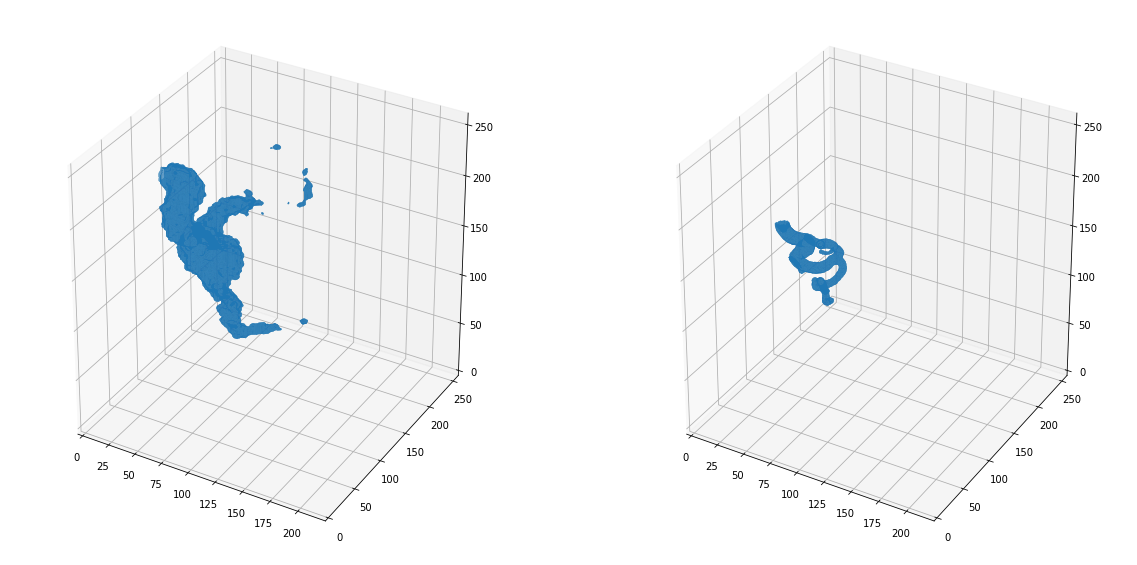

In [38]:
index = 4
utils.plot_3d(unpaded_images[index], y_list[index], threshold=0.5, threshold2=0.5)